# The Data

The work performed herein was built off of the shoulders of giants, the original project that created the dataset and labeled the images. Here follows an excerpt from their site describing the data.

> [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.4002935.svg)](https://doi.org/10.5281/zenodo.4002935)
>__Project member(s)__:\
>Topher Allen; Zach Anderson; Berlin Chen; Ameya Daigavane; Annie Didier; Marko Green; Paul Horton; Hannah Kerner; Lauren Klein; Benjamin Kolber; Ellie Kuang; Kyle Kung; Jake Lee; Justin Martia; Brian Milch; James Montgomery; Kyle Pearson; Sanjna Ravichandar; Arun Viswanathan; Caleb Wagner; Amruta Yelamanchili; Brandon Zhao
>
>__Abstract__:\
>This dataset contains a total of 64,947 landmark images that were detected and extracted from HiRISE browse images, spanning 232 separate source images.
>
>This set was formed from 10,815 original landmarks. Each original landmark was cropped to a square bounding box that included the full extent of the landmark plus a 30-pixel margin to the left, right, top, and bottom. Each landmark was then resized to 227x227 pixels. 9,022 of these images were then augmented to generate 6 additional landmarks using the following methods:
>
>90 degrees clockwise rotation
>180 degrees clockwise rotation
>270 degrees clockwise rotation
>Horizontal flip
>Vertical flip
>Random brightness adjustment
>The remaining 1,793 images were not augmented. Combining these with the 7*9,022 images, gives a total of 64,947 separate images.
>
> __Contents__:
>- map-proj-v3_2/: Directory containing individual cropped landmark images
>- labels-map-proj-v3_2.txt: Class labels (ids) for each landmark image. File includes two columns separated by a space: filename, class_id
>- labels-map-proj-v3_2_train_val_test.txt: Includes train/test/val labels and upsampling used for trained model. File includes three columns separated by a space: filename, class_id, set
>- landmarks_map-proj-v3_2_classmap.csv: Dictionary that maps class ids to semantic names
>
> __Class Discussion__:\
>We give a discussion of the various landmarks that make up our classes.
>
>Bright dune and dark dune are two sand dune classes found on Mars. Dark dunes are completely defrosted, whereas bright dunes are not. Bright dunes are generally bright due to overlying frost and can exhibit black spots where parts of the dune are defrosting.
>
>The crater class consists of crater images in which the diameter of the crater is greater than or equal to 1/5 the width of the image and the circular rim is visible for at least half the crater's circumference.
>
>The slope streak class consists of images of dark flow-like features on slopes. These features are believed to be formed by a dry process in which overlying (bright) dust slides down a slope and reveals a darker sub-surface.
>
>Impact ejecta refers to material that is blasted out from the impact of a meteorite or the eruption of a volcano. We also include cases in which the impact cleared away overlying dust, exposing the underlying surface. In some cases, the associated crater may be too small to see. Impact ejecta can also include lava that spilled out from the impact (blobby ("lobate") instead of blast-like), more like an eruption (triggered by the impact). Impact ejecta can be isolated, or they can form in clusters when the impactor breaks up into multiple fragments.
>
>Spiders and Swiss cheese are phenomena that occur in the south polar region of Mars. Spiders have a central pit with radial troughs, and they are believed to form as a result of sublimation of carbon dioxide ice. This process can produce mineral deposits on top, which look like dark or light dust that highlights cracks in the CO2 ice. Spiders can resemble impact ejecta due to their radial troughs, but impact ejecta tends to have straight radial jets that fade as they get farther from the center. The spider class also includes fan-like features that form when a geyser erupts through the CO2 layer and the material is blown by the wind away from the cracks. Fans are typically unidirectional (following the wind direction), whereas impact ejecta often extends in multiple directions. Swiss cheese is a terrain type that consists of pits that are formed when the sun heats the ice making it sublimate (change solid to gas).
>
>Other is a catch-all class that contains images that fit none of the defined classes of interest. This class makes up the majority of our data set.


# Business Understanding

Space exploration and understanding has been growing over the last few decades with the spark being lit during the space race during the latter half of the 20th century. After the end of the Apollo space program, man's venture into space has been relegated to low earth orbit missions.  

Unmanned missions have since had many a success story such as the Voyager 2 going interstellar in 2018, over 40 years after its launch. The future of space exploration is going to be handled by such manned missions for the foreseeable future. However, being physically on site isn't the only way to explore space.  

For centuries, man has looked up at the night sky to find out more about our celestial neighbors. With improvements in technologies our ability to gather data through telescopes and cameras has improved significantly and the value provided by telescopes in space has been immeasurable. The James Webb (infrared) telescope was launched in December 2021 and hopes to view objects too old, distant, and faint for the Hubble Space Telescope.

Pointing the telescope and gathering data is only the first step. Being able to parse terabytes, petabytes or even yottabytes of data manually is a nigh impossible task, a task computer vision is especially suited for. Being able to identify interesting features can help us whittle down potential candidates to explore 'in-person' and in the long run help mitigate losses.

Interest in space exploration has seen a resurgence with private enterprise taking an interest. Although this project specifically looks at the Mars topography, similar techniques can be applied to any celestial body, or even to our home planet.

# Overview
We shall be using images captured from the HiRISE camera system on board the Mars Reconnaisance Orbiter which was built under direction from University of Arizona's Lunar and Planetary Laboratory. Following is an excerpt from the [University of Arizona website](https://www.lpl.arizona.edu/missions/hirise-mro).

>The __Hi__gh __R__esolution __I__maging __S__cience __E__xperiment (HiRISE) onboard the Mars Reconnaissance Orbiter, is the most powerful camera ever sent to another planet. The resolution of the camera allows us to see the Red Planet in amazing detail, and lets other missions, like the Mars Science Laboratory, find a safe place to land and carry out amazing science. The operations center, which includes not only observation planning, but the execution of commands sent to the spacecraft along with actual image processing, is located within LPL at the University of Arizona.

We shall be building off of the work performed by the original team. The dataset comes pre-augmented and segmented into training, validation and test sets. The test side will be set aside to ascertain effectiveness of our final model. The training set will be used to train the model and the validation scores on the validation set will be used as a metric to pick our model, specifically our validation loss.

# Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf
tf.random.set_seed(
    42
)
import seaborn as sns

tf_chkpt_path = 'tf_AlexNet_checkpoints/'

In [5]:
from src.helperFunctions import display_model_trainTestGraphs

## Training Set

In [6]:
# Normalizing data for 8 bit
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'images/train/',
    target_size = (227,227),
    batch_size=225,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 48979 images belonging to 8 classes.


## Validation Set

In [7]:
# Normalizing data for 8 bit
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    'images/val/',
    target_size = (227,227),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 14175 images belonging to 8 classes.


## Test Set

In [8]:
# Normalizing data for 8 bit
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'images/test/',
    target_size = (227,227),
    batch_size=8,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 1793 images belonging to 8 classes.


# Modeling

## Modeling Callbacks
Tensorflow's neural networks employs callbacks which allow for additional features. EarlyStop is one such feature which allows us to quit the modeling process early especially if the model has started to diverge. Since the metric to watch is validation loss, we shall employ an early stop which will kill the modeling process if validation loss does not decrease for 10 epochs. As an added bonus, the models best epoch weights will be retained instead of the final epoch scores

In [22]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=1e-8,
                           verbose=1,
                           patience = 5,
                           restore_best_weights=True,
                           mode='min')

# Model - LeNet - 5
The LeNet-5 architecture was one of the first big Convolutional Networks that became widely known. It was created in 1998 by Yann LeCun for recognizing hand written digits in the MNIST dataset.
We shall run two variations of this architecture. The first is going to be an exact replica of the LeNet-5 architecture.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 227, 227, 6)       156       
                                                                 
 average_pooling2d (AverageP  (None, 113, 113, 6)      0         
 ooling2D)                                                       
                                                                 
 activation (Activation)     (None, 113, 113, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 54, 54, 16)       0         
 ePooling2D)                                                     
                                                                 
 activation_1 (Activation)   (None, 54, 54, 16)        0

Epoch 29/30
218/218 [==============================] - 35s 160ms/step - loss: 0.0941 - accuracy: 0.9810 - precision: 0.9844 - recall: 0.9768 - val_loss: 0.8695 - val_accuracy: 0.7894 - val_precision: 0.8041 - val_recall: 0.7740
Epoch 30/30
218/218 [==============================] - 35s 162ms/step - loss: 0.0877 - accuracy: 0.9829 - precision: 0.9861 - recall: 0.9789 - val_loss: 0.8822 - val_accuracy: 0.7733 - val_precision: 0.7927 - val_recall: 0.7525


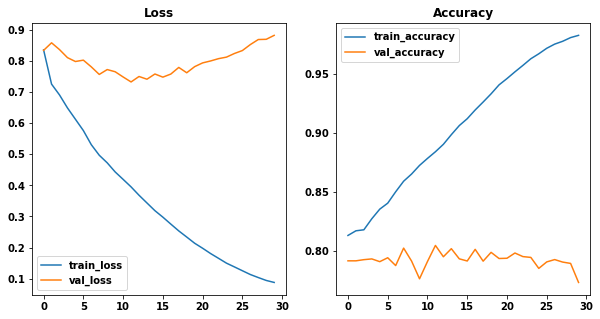

In [10]:
model = models.Sequential()
model.add(layers.Conv2D(filters=6, kernel_size=5, activation='tanh', padding='same',strides=1,
                        input_shape=(227, 227, 1)))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('tanh'))
model.add(layers.Conv2D(filters=16, kernel_size=5, activation='tanh', padding='valid',strides=1,))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('tanh'))
model.add(layers.Conv2D(filters=120, kernel_size=5, activation='tanh', padding='valid',strides=1,))
model.add(layers.Flatten())
model.add(layers.Dense(84, activation='tanh'))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer = optimizers.Adam(learning_rate=0.0001),
              loss= losses.CategoricalCrossentropy(),
              metrics = ['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    epochs=30,  # Number of epochs
                    validation_data=val_generator,
                    validation_freq=1,
                    )

display_model_trainTestGraphs(results)

In [11]:
results.model.save(tf_chkpt_path+'Model_1')

INFO:tensorflow:Assets written to: tf_leNet_checkpoints/Model_1\assets


INFO:tensorflow:Assets written to: tf_leNet_checkpoints/Model_1\assets


The model performance on both validation loss and accuracy is terrible. We shall employ `sigmoid` activation function instead of `tanh` between each set of convolution and pooling layers.

# Model - LeNet - 5 - Sigmoid between convolutions

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 227, 227, 6)       156       
                                                                 
 average_pooling2d_2 (Averag  (None, 113, 113, 6)      0         
 ePooling2D)                                                     
                                                                 
 activation_2 (Activation)   (None, 113, 113, 6)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 16)      2416      
                                                                 
 average_pooling2d_3 (Averag  (None, 54, 54, 16)       0         
 ePooling2D)                                                     
                                                                 
 activation_3 (Activation)   (None, 54, 54, 16)       

Epoch 28/30
218/218 [==============================] - 35s 162ms/step - loss: 0.7834 - accuracy: 0.8171 - precision_1: 0.8171 - recall_1: 0.8171 - val_loss: 0.8601 - val_accuracy: 0.7916 - val_precision_1: 0.7916 - val_recall_1: 0.7916
Epoch 29/30
218/218 [==============================] - 36s 163ms/step - loss: 0.7834 - accuracy: 0.8171 - precision_1: 0.8171 - recall_1: 0.8171 - val_loss: 0.8637 - val_accuracy: 0.7916 - val_precision_1: 0.7916 - val_recall_1: 0.7916
Epoch 30/30
218/218 [==============================] - 35s 160ms/step - loss: 0.7834 - accuracy: 0.8171 - precision_1: 0.8171 - recall_1: 0.8171 - val_loss: 0.8615 - val_accuracy: 0.7916 - val_precision_1: 0.7916 - val_recall_1: 0.7916


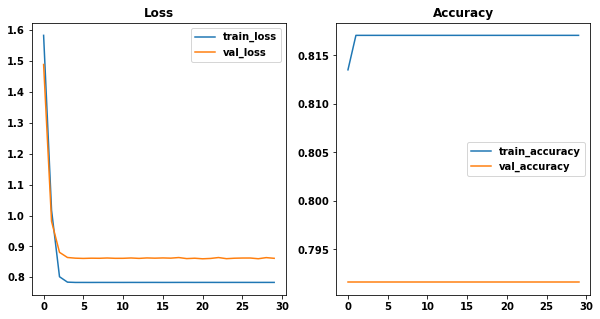

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(filters=6, kernel_size=5, activation='tanh', padding='same',strides=1,
                        input_shape=(227, 227, 1)))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv2D(filters=16, kernel_size=5, activation='tanh', padding='valid',strides=1,))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv2D(filters=120, kernel_size=5, activation='tanh', padding='valid',strides=1,))
model.add(layers.Flatten())
model.add(layers.Dense(84, activation='tanh'))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer = optimizers.Adam(learning_rate=0.0001),
              loss= losses.CategoricalCrossentropy(),
              metrics = ['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
#                     steps_per_epoch=200,  # Number of training samples to pull per epoch
                    epochs=30,  # Number of epochs
                    validation_data=val_generator,
                    validation_freq=1,
#                     validation_steps=200,  # Number of validation samples to run validation on
                    )

display_model_trainTestGraphs(results)

In [13]:
results.model.save(tf_chkpt_path+'Model_2_sigmoid')

INFO:tensorflow:Assets written to: tf_leNet_checkpoints/Model_2_sigmoid\assets


INFO:tensorflow:Assets written to: tf_leNet_checkpoints/Model_2_sigmoid\assets


Model performance is no better. Focusing our efforts on other more promising models.